<a href="https://colab.research.google.com/github/Lelouchlamperougexd/article_experiment/blob/main/new_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install dependencies
!pip install datasets pandas numpy torch tqdm faiss-cpu sentence-transformers transformers rank_bm25 llama-index kaggle

# Import required libraries
import os
import json
import pandas as pd
import numpy as np
import torch
import faiss
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from rank_bm25 import BM25Okapi
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Set up Kaggle API and download dataset
print("Downloading ArXiv dataset from Kaggle...")
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
!kaggle datasets download -d cornell-university/arxiv --unzip

Dataset URL: https://www.kaggle.com/datasets/cornell-university/arxiv
License(s): CC0-1.0
100% 1.41G/1.41G [00:42<00:00, 42.9MB/s]
100% 1.41G/1.41G [00:42<00:00, 35.4MB/s]


In [4]:
# Load ArXiv dataset
print("Loading ArXiv dataset...")
FILE_PATH = "arxiv-metadata-oai-snapshot.json"
with open(FILE_PATH, "r") as f:
    arxiv_data = [json.loads(line) for line in f]

docs_arxiv_df = pd.DataFrame(arxiv_data)
docs_arxiv_df = docs_arxiv_df[['id', 'title', 'abstract', 'categories', 'update_date']]
docs_arxiv_df['full_text'] = docs_arxiv_df['title'] + ". " + docs_arxiv_df['abstract'].fillna("")
docs_arxiv_df['update_date'] = pd.to_datetime(docs_arxiv_df['update_date'], errors='coerce')
docs_arxiv_df = docs_arxiv_df.dropna(subset=['update_date'])

Loading ArXiv dataset...


In [5]:
# Filter papers (old <2020, new >=2021)
print("Filtering dataset...")
old_docs_df = docs_arxiv_df[docs_arxiv_df['update_date'] < '2020-01-01'].sample(n=5000, random_state=42)
new_docs_df = docs_arxiv_df[docs_arxiv_df['update_date'] >= '2021-01-01'].sample(n=5000, random_state=42)

# Create FAISS index
print("Creating FAISS index...")
model = SentenceTransformer('all-MiniLM-L6-v2')
old_embeddings = model.encode(old_docs_df['full_text'].tolist(), convert_to_tensor=True).cpu().numpy()
faiss.normalize_L2(old_embeddings)
index = faiss.IndexFlatIP(old_embeddings.shape[1])
index.add(old_embeddings)

# Create BM25 Index
print("Creating BM25 index...")
tokenized_corpus = [doc.split() for doc in old_docs_df['full_text'].tolist()]
bm25 = BM25Okapi(tokenized_corpus)

Filtering dataset...
Creating FAISS index...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating BM25 index...


In [6]:
# Define Novelty Evaluation Function
def evaluate_novelty(new_text, top_k=5, alpha=0.5):
    """Evaluate novelty using hybrid search and keyword uniqueness."""
    # FAISS retrieval
    new_embedding = model.encode([new_text], convert_to_tensor=True).cpu().numpy()
    faiss.normalize_L2(new_embedding)
    scores, indices = index.search(new_embedding, k=top_k)
    avg_similarity = np.mean(scores)

    # BM25 retrieval
    bm25_scores = bm25.get_scores(new_text.split())
    top_bm25_indices = np.argsort(bm25_scores)[-top_k:]
    avg_bm25_score = np.mean([bm25_scores[i] for i in top_bm25_indices])

    # Keyword uniqueness
    words = Counter(new_text.split())
    unique_score = sum(1 for w in words if words[w] == 1) / len(words)

    # Combined novelty score
    novelty_score = (1 - avg_similarity) * alpha + unique_score * (1 - alpha)
    return novelty_score

In [7]:
# Evaluate novelty for new papers
print("Evaluating novelty of new papers...")
novelty_results = []
for _, row in tqdm(new_docs_df.iterrows(), total=len(new_docs_df)):
    novelty_score = evaluate_novelty(row['full_text'])
    novelty_results.append({'doc_id': row['id'], 'title': row['title'], 'novelty_score': novelty_score})

Evaluating novelty of new papers...


100%|██████████| 5000/5000 [38:50<00:00,  2.15it/s]


In [8]:
# Save Results
novelty_df = pd.DataFrame(novelty_results).sort_values(by='novelty_score', ascending=False)
novelty_df.to_csv("novelty_results.csv", index=False)
print("Saved novelty results to novelty_results.csv")


Saved novelty results to novelty_results.csv


In [9]:
# sort by novelty
novelty_df = pd.DataFrame(novelty_results).sort_values(by='novelty_score', ascending=False)
print("Top 10 most novel papers:")
print(novelty_df.head(10))

Top 10 most novel papers:
          doc_id                                              title  \
16    2110.03526  Tissue Engineering of Skin Regeneration and Ha...   
3528  2410.17805  Experimental Demonstration of End-to-End Optim...   
2907  2108.00867  Overview of the global semiconductor industry ...   
4818  2402.15288  Real-Time FPGA Demonstrator of ANN-Based Equal...   
4700  2210.14693  On the positivity of a certain function relate...   
3550  2211.02992                                      Foon Creation   
4601  2407.10367  Perceptions of Entrepreneurship Among Graduate...   
2345  2404.10281  AI-Assisted Writing in Education: Ecosystem Ri...   
4243  2309.03498  How life-table right-censoring affected the Br...   
3809  2311.09232  What Attracts Employees to Work Onsite in Time...   

      novelty_score  
16         0.814125  
3528       0.791581  
2907       0.783224  
4818       0.783108  
4700       0.779938  
3550       0.779382  
4601       0.773084  
2345       0.771

In [10]:
print(novelty_df["novelty_score"].describe())

count    5000.000000
mean        0.631957
std         0.049247
min         0.402343
25%         0.599916
50%         0.633283
75%         0.665335
max         0.814125
Name: novelty_score, dtype: float64


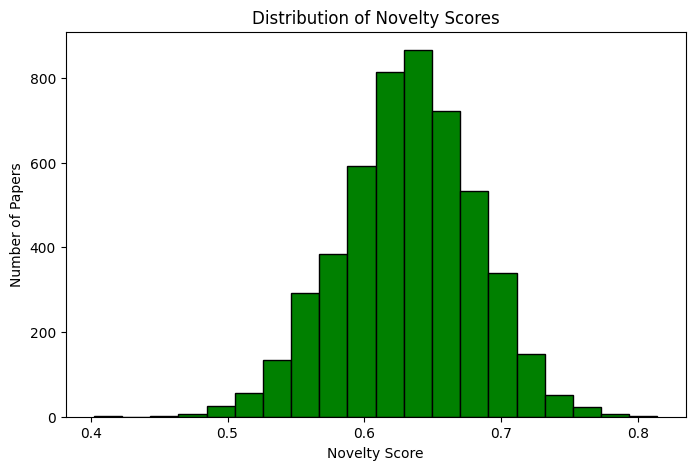

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(novelty_df["novelty_score"], bins=20, color="green", edgecolor="black")
plt.xlabel("Novelty Score")
plt.ylabel("Number of Papers")
plt.title("Distribution of Novelty Scores")
plt.show()

In [12]:
print(novelty_df.nsmallest(10, "novelty_score"))

          doc_id                                              title  \
3592  2105.08044  A smooth complex rational affine surface with ...   
118   2212.00494  Left-invariant Ricci collineations associated ...   
1312  2403.14873  Origin of the correlation between stellar kine...   
2468  2312.04399  Resonant leptogenesis in minimal inverse seesa...   
2810  2402.06257  Intermediate inflation in generalized non-mini...   
1876  2503.03242  Chemical signature reveals co-spatial dwarf sa...   
3783  2405.12585  Chemical evolution of the Galactic bulge with ...   
1970  2206.14273  Asymptotic bounds for the number of closed and...   
2347  2011.08240  Chiral gauge leptoquark mass limits and branch...   
1136  2211.07952  Complete monogamy of the multipartite quantum ...   

      novelty_score  
3592       0.402343  
118        0.414158  
1312       0.447025  
2468       0.451360  
2810       0.467679  
1876       0.471672  
3783       0.472397  
1970       0.475193  
2347       0.476534 

In [15]:
def evaluate_user_paper(text, top_k=5, alpha=0.5):
    """Evaluate novelty of a user-provided paper."""
    new_embedding = model.encode([text], convert_to_tensor=True).cpu().numpy()
    faiss.normalize_L2(new_embedding)
    scores, indices = index.search(new_embedding, k=top_k)
    avg_similarity = np.mean(scores)

    bm25_scores = bm25.get_scores(text.split())
    top_bm25_indices = np.argsort(bm25_scores)[-top_k:]
    avg_bm25_score = np.mean([bm25_scores[i] for i in top_bm25_indices])

    words = Counter(text.split())
    unique_score = sum(1 for w in words if words[w] == 1) / len(words)

    novelty_score = (1 - avg_similarity) * alpha + unique_score * (1 - alpha)
    return novelty_score

# Example usage:
user_text = """Purpose
The purpose of this study is to describe the opportunities and limitations of cryptocurrencies as a tool for money laundering through six currently available “open doors” (exchange mechanisms). The authors link the regulatory dialectic paradigm to know your customer and anti-money laundering evasion techniques, highlight six tactics to launder funds with virtual assets and investigate potential law enforcement and regulatory alternates used to reduce the incidence of money laundering with digital coins.

Design/methodology/approach
The methodology used is the analysis of significant recent events and the availability of “fintech” crime-fighting tools and a literature review focusing on the application of the regulatory dialectic to innovations in existing crypto-asset markets that make them compelling to money launderers.

Findings
The authors examine the illicit use of cryptocurrency through Kane’s regulatory dialectic paradigm, identify a number of avenues for crypto to fiat exchange that are still available for those seeking to launder money using digital coins, review recently “closed doors” and make recommendations regarding the regulation of crypto-related markets that may assist in making them less desirable for potential criminals.

Research limitations/implications
The research is constrained by the state of the market for crypto to fiat exchange as of time of writing; the technology and products to launder money using these open doors is continually changing (as predicted by the regulatory dialectic).

Social implications
The regulatory dialectic predicts that regulatory response is reactive and often increasingly burdensome or oppressive. There is continuous innovation in the cryptocurrency market, which seeks to preserve privacy and anonymity with which regulators seek to keep up. From a social perspective, the response of bank regulators worldwide to existing open doors for crypto to fiat exchange used for money laundering may prove costly to individuals engaging in legitimate transactions, as well as financial criminals and may also erode the ability of individuals to maintain privacy regarding their financial information.

Originality/value
To the authors’ knowledge, there are yet no broad overview regarding the feasibility of money laundering across crypto-related assets within the paradigm of the regulatory dialectic.

Keywords"""
novelty = evaluate_user_paper(user_text)
print(f"Novelty Score: {novelty:.4f}")


Novelty Score: 0.6907
